# Kona Coffee - Research Update: December 2023

Since the launch of this project at the start of October 2023, we have made significant progress towards models and methods that could bring great value to the industry and to local farmers. In close collaboration with Mountain Thunder Coffee Plantation, we have been able to collect a large dataset of images of coffee trees, berries, and leaves.

The most significant progress has been made in the following areas:

- We have shown that berries, segmented with the SegmentAnything model, can be classified into different categories of "unripe", "ripening", and "ripe" with a high degree of precision and recall.

- We have shown that leaf rust can be detectable within regions of images. This can generate heatmaps of the affected areas which can serve as an indication of the spread of leaf rust throughout a given tree.

- Finally, we have also shown that the annotation process can be signficantly automated and accelerated to obtain classes and instance masks with the use of the SegmentAnything model, and several annotation tools built with OpenCV.

# Berry Classification

The berry classification model is just one of the proposed models of the research. It's goal is to automatically segment and classify berries into three different categories: "unripe", "ripening", and "ripe". Since the segmentation of the berries requires instance masks, we had to develop an annotation pipeline that allows us to quickly get the instance mask of the berries. The pipeline is as follows:


## Split

Split the images into 400px x 400px tiles. Since the images are high resolution and taken in RAW format, they are upwards of 50MB each. Splitting them into tiles allows us to work with smaller images and speeds up the annotation process. But, it does generate a huge amount of images to search through!

In [3]:
import os

file_exts = ['.jpg', '.png', '.cr2']

raw_images_paths = [
    '/home/jack/Mounts/RemoteS3/kona_coffee_images/samples/all',
    '/home/jack/Mounts/RemoteS3/kona_coffee_images/raw/02-12-2023/raws',
    '/home/jack/Mounts/RemoteS3/kona_coffee_images/raw/02-12-2023/phone'
]

splits_path = '/home/jack/Mounts/DiskOne/kona_coffee/splits'

def recursive_list(dir_path, any=False):
    file_list = []
    for root, directories, filenames in os.walk(dir_path):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            if os.path.isfile(file_path):
                if any:
                    file_list.append(file_path)
                elif os.path.splitext(file_path)[1].lower() in file_exts:
                    file_list.append(file_path)
    return file_list

raw_images = [image for path in raw_images_paths for image in recursive_list(path)]
splits_images = recursive_list(splits_path)

print(f'Total Raw Images: {len(raw_images)}')

print(f'Total Split Images: {len(splits_images)}')

Total Raw Images: 369
Total Split Images: 35370


## Filter

Filter the images with a simple boolean answer of whether or not there are berries present in the image. This can be quickly done manually as berries are easily distinguishable from the background.

## Annotate

Annotate the berries by placing a single point in the center of each berry that is present. This is the most time consuming part of the process, but it is still significantly faster than drawing the entire bounding box.

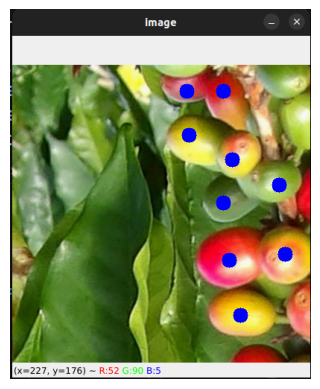

In [4]:
from matplotlib import pyplot as plt
import cv2

image = cv2.imread('./annotate.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

## Segment

Segment the berries utilizing the SegmentAnything model. Utilizing the selected point that was annotated, we can attempt to segment the berries. Since the model is quite large, and we can have upwards of 20 annotates per image, we utilize the FastSAM model to quickly iterate through the annotations.

A little bit a devops work was involved as well. The installation of the FastSAM model is quite complex. But, after some dockerization, a simple Flask App, and an in-memory caching solution for images with multiple annotations, we were able to deploy an API via Kubernetes that can be scaled up to segment many images at a time.

[FastSAM Model API Image](https://hub.docker.com/repository/docker/jackmead515/fast-sam-api/general)

```bash
(base) λ ~/ kubectl get pods -n default
NAME                            READY   STATUS        RESTARTS       AGE
fast-sam-api-6c95d6f947-dw6p9   1/1     Terminating   9 (45d ago)    52d
fast-sam-api-594455b6f5-h2ntz   1/1     Running       8 (25h ago)    16d
fast-sam-api-594455b6f5-6kjkv   1/1     Running       10 (25h ago)   17d
fast-sam-api-594455b6f5-dvj6t   1/1     Running       0              17d
fast-sam-api-594455b6f5-d275v   1/1     Running       0              16d
fast-sam-api-594455b6f5-98hrq   1/1     Running       0              17d
fast-sam-api-594455b6f5-6tz8n   1/1     Running       0              17d
```

## Validate

Validate the segmentation from FastSAM by anaylzing if the instance mask covers the entire berry. If it's not, we simply discard the annotation and move on to the next one. We could correct the model, but since there are so many berries in the dataset, we don't need to worry about it.

The model had a habit of detecting the background or having multiple berries within a single mask. This step filtered out many of those cases.

In [5]:
import pandas as pd

sdf = pd.read_csv('/home/jack/Documents/Workspace/kona_coffee/berries/segmented.csv')
vdf = pd.read_csv('/home/jack/Documents/Workspace/kona_coffee/berries/validated.csv')

print(f'Total Segmented: {len(sdf)}')
print(f'Total Validated: {len(vdf)}')

Total Segmented: 5154
Total Validated: 4234


## Classify

Finally we classify the berries into the three categories. Mostly, this comes down to the color of the berry for which we could have merged the "validate" step into this step. However, we wanted to keep the two steps separate to allow us to quickly generate a dataset for the instance segmentation as opposed to the classification.

Given that the images were taken from a production field, were ripe berries are actively being harvested, we see a large inbalance in the dataset. There are significantly more "unripe" berries than there are "ripening" or "ripe" berries.

In [8]:
cdf = pd.read_csv('/home/jack/Documents/Workspace/kona_coffee/berries/classified.csv')

print(cdf['lifecycle'].value_counts())

lifecycle
unripe      1371
ripe         532
ripening     384
unknown      109
overripe       2
Name: count, dtype: int64


Furthermore, classification of the berries is not perfect. There is a potential for high bias, as berries aren't nessesarily more yellow or red as they ripen. Some varieties of coffee berries are more naturally yellow than green and doesn't necessarily indicate ripeness. We see this as there is a inbalance in the precision and recall of the ripening berries versus the other berries.

Using a basic machine learning approach with LogisiticRegression, the classification report showed us:
```bash
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       104
           1       0.82      0.67      0.74        86
           2       0.89      0.95      0.92       110

    accuracy                           0.86       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.86      0.85       300
```

From the other models, we also see a poorer performance in the F1 score for the "ripening" berries. More can be read about this in my classification report: [Classification Report](https://jackmead515.github.io/posts/kona_coffee_ibm_dl)

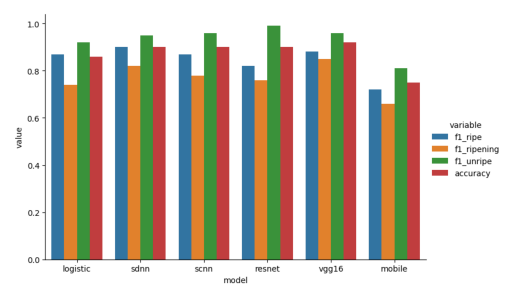

In [7]:
image = cv2.imread('./comparison.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

## Train Segmentation Model

Utilizing YoloV8, we attempted to train a segmentation model to detect the berry masks but were unable to see significant results. The error rates on convergence were quite high. We can see from the validation image, that many berries are simply not detected at all. Further research is needed to determine if this is a problem with the model, or if the dataset is simply too small. Steps are being taken to increase the dataset size by contracting out some of the labor.

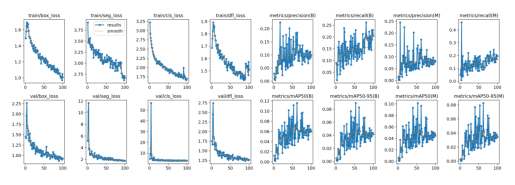

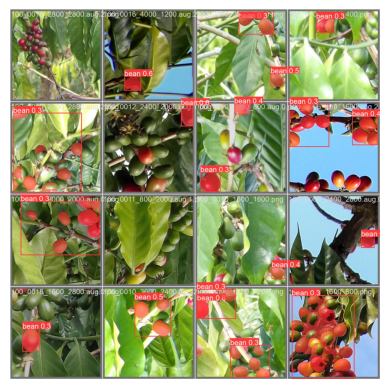

In [10]:
image = cv2.imread('./segmentation_results.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

image = cv2.imread('./validation_batch.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

# Leaf Rust Detection

Along with berry classification, leaf rust detection is also a proposed model of the research. The goal with the model is to detect the presence of leaf rust in a given tree and show the spread throughout a given tree and throughout a given region within a field.

The first methodology being researched is to attempt to segment the images into small regions of 64px x 64px and classify each region as either "leaf rust" or "no leaf rust". This has already shown great promise as a dataset can be quickly gathered by scanning over the image using OpenCV.

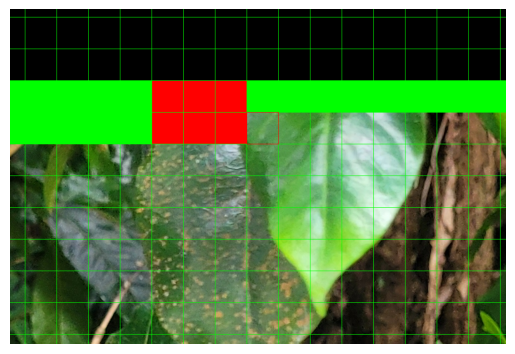

In [11]:
image = cv2.imread('./leaf_rust_annotation.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

Using this annotation tool, we have already generated a large dataset with only a few evenings of annotation and only a few images from the field.

In [12]:
adf = pd.read_csv('/home/jack/Documents/Workspace/kona_coffee/leaves/classified.csv')

print(adf['rust'].value_counts())

rust
0    18846
1     2921
Name: count, dtype: int64


Training a simple convolution neural network on this dataset with data augmentation enabled, we see really great results for the training and the testing set. However, given the few images that we have, there is a high potential for overfitting. We will need to gather more images to determine if this is the case.

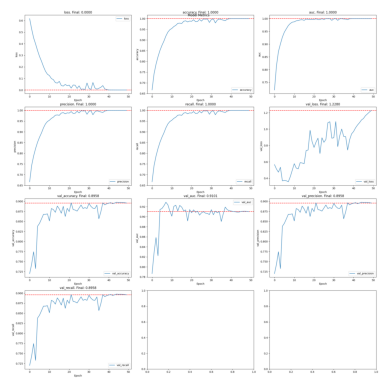

In [13]:
image = cv2.imread('./rust_training.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

```bash
# test set classification report

              precision    recall  f1-score   support

     no_rust       0.92      0.87      0.89      2179
        rust       0.88      0.92      0.90      2203

    accuracy                           0.90      4382
   macro avg       0.90      0.90      0.90      4382
weighted avg       0.90      0.90      0.90      4382
```

When we examine an image that the model has not seen, we see that the model is already able to detect the presence of leaf rust. However, it still appears to not detect all the leaf rust that is present.

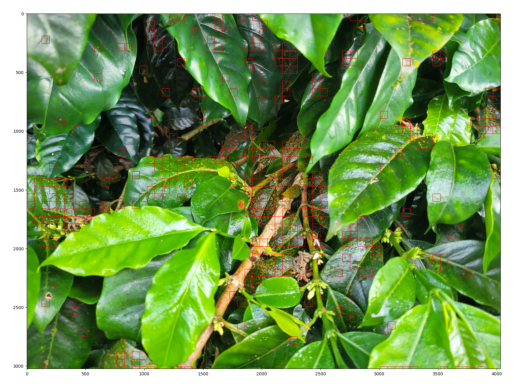

In [14]:
image = cv2.imread('./leaf_rust_example.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

Much more annotation needs to be done to determine if the model results can be improved. We are also researching other methods of detecting leaf rust, such as object detection and semantic segmentation.

# Final Remarks

The research is still in progress and there is much more work to be done. We are currently working on the annotation portion of the project and gathering more data. We now have two test sites avaliable to us, one that is organic and one that is not. This creates a perfect mix of data to train on where we can ensure that we get a variety of healthy and unhealthy samples, different species of coffee, and different maintainence practices.

So far, there is no indiciation that the models will not be able to be trained on a larger dataset and be able to be deployed into production usage. However, the data capture metholodogies may prove challenging. We are currently also researching the use of high resolution cameras and drone footage to make data capture easier and more efficient.

A huge thanks goes out to the Mountain Thunder Coffee Plantation for making this data capture possible. They have been very supportive of the project and have been very helpful in the data capture process along with providing us with a lot of insight into the coffee industry and the challenges that they face.

And I have to say, the coffee is truly amazing. I highly recommend it!

[Mountain Thunder Coffee Plantation](https://www.mountainthunder.com/)